In [1]:
import sys
sys.path.append("./../common/")
from utils import *
from config import *

import dill
sys.path.append("./TyXe/")
import tyxe # from https://github.com/TyXe-BDL/TyXe
from functools import partial
import torch
import pyro

# configuring to be deterministic for reproducibility
tf.keras.utils.set_random_seed(RND_SEED)
tf.config.experimental.enable_op_determinism()
pyro.set_rng_seed(RND_SEED)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 2.10.0


/Users/mateusz/miniforge3/envs/ml_tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_dataset(N):
    m, c = 0.2, 0.1
    sd_e = 0.02

    x_train = np.linspace(0, 0.5, N)[:, np.newaxis]
    y_train = m*(x_train + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c
    x_test = np.linspace(0.5, 1, N)[:, np.newaxis]
    y_test = m*(x_test + np.random.normal(0, sd_e, N).reshape(-1, 1)) + c

    return x_train, y_train, x_test, y_test

def numpy_dataset_to_tensors(x_train, y_train, x_test, y_test):
    return torch.from_numpy(x_train).to(dtype=torch.float32), torch.from_numpy(y_train).to(dtype=torch.float32), torch.from_numpy(x_test).to(dtype=torch.float32), torch.from_numpy(y_test).to(dtype=torch.float32)

def get_dataloader(x, y):
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x, y), batch_size=len(x))

def build_train_simple_NN(x_train, y_train, epochs):
    # build NN
    model = torch.nn.Sequential(torch.nn.Linear(1, 8),
                      torch.nn.ReLU(),
                      torch.nn.Linear(8, 1))
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # train NN
    losses = []
    best_state = None
    min_loss = np.inf
    for _ in range(epochs):
        y_pred = model(x_train)
        loss = loss_function(y_pred, y_train)
        losses.append(loss.item())
        if loss.item() <= min_loss:
            best_state = model.state_dict()
            min_loss = loss.item()
        model.zero_grad()
        loss.backward()
        optimizer.step()

    model.load_state_dict(best_state)
    return model, losses

def get_bnn_outputs(bnn, x, K):
    bnn_outputs = bnn.predict(x, num_predictions=K, aggregate=False)
    y_hat = bnn_outputs.mean(axis=0).flatten()
    sd_hat = bnn_outputs.std(axis=0).flatten()
    return y_hat, sd_hat

In [3]:
x_train, y_train, x_test, y_test = create_dataset(1000)
x_train_t, y_train_t, x_test_t, y_test_t = numpy_dataset_to_tensors(x_train, y_train, x_test, y_test)

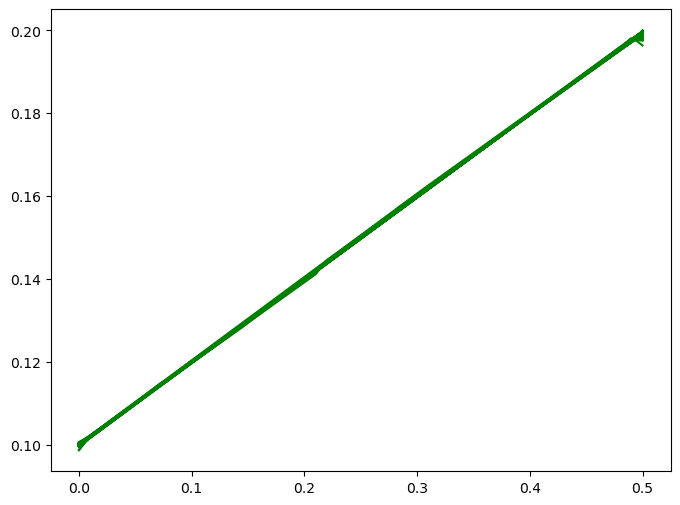

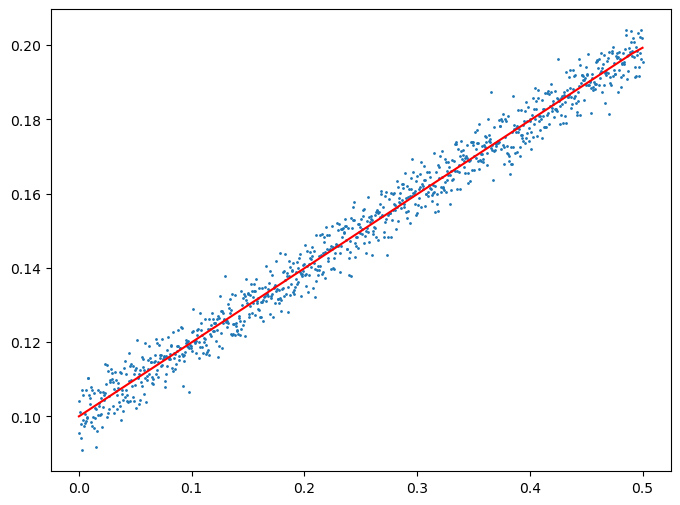

In [4]:
# model uncertainty for ensemble of networks
K = 100
epochs = 50000

def train_one_network(i):
    model, _ = build_train_simple_NN(x_train_t, y_train_t, epochs)
    return model

# train K networks
with multiprocessing.pool.ThreadPool(PROCESSORS) as pool:
    ensemble_networks = pool.map(train_one_network, range(K))

def get_ensemble_outputs(ensemble_networks, x, train=False):
    ensemble_outputs = []
    for network in ensemble_networks:
        with torch.no_grad():
            output = network(x).numpy()
        ensemble_outputs.append(output)
        if train:
            plt.plot(x.numpy(), output, c='green')
    ensemble_outputs = np.array(ensemble_outputs)
    y_hat = ensemble_outputs.mean(axis=0).flatten()
    sd_hat = ensemble_outputs.std(axis=0).flatten()
    return y_hat, sd_hat

ensemble_y_hat_train, ensemble_sd_hat_train = get_ensemble_outputs(ensemble_networks, x_train_t, train=True)
ensemble_y_hat_test, ensemble_sd_hat_test = get_ensemble_outputs(ensemble_networks, x_test_t)

fig = plt.figure()
plt.scatter(x_train, y_train, s=1)
plt.plot(x_train, ensemble_y_hat_train, c='r')
plt.show()

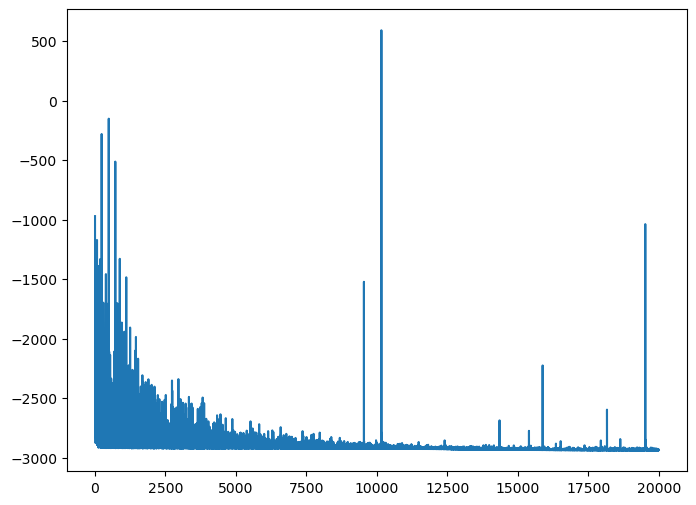

In [5]:
# model uncertainty for BNN using VI
K = 1000
epochs = 20000

# build bnn using tyxe, adapted from https://github.com/TyXe-BDL/TyXe/blob/master/notebooks/regression.ipynb
net = torch.nn.Sequential(torch.nn.Linear(1, 4), torch.nn.ReLU(), torch.nn.Linear(4, 1))
prior = tyxe.priors.IIDPrior(pyro.distributions.Normal(0, 1))
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(x_train_t), scale=0.02)
guide = partial(tyxe.guides.AutoNormal, init_scale=0.01)
vi_bnn = tyxe.VariationalBNN(net, prior, likelihood, guide)

# train bnn
pyro.clear_param_store()
loss = []
def callback(vi_bnn, i, e):
    loss.append(e)
vi_bnn.fit(get_dataloader(x_train_t, y_train_t), pyro.optim.Adam({"lr": 1e-3}), epochs, callback)
plt.plot(loss)
plt.show()

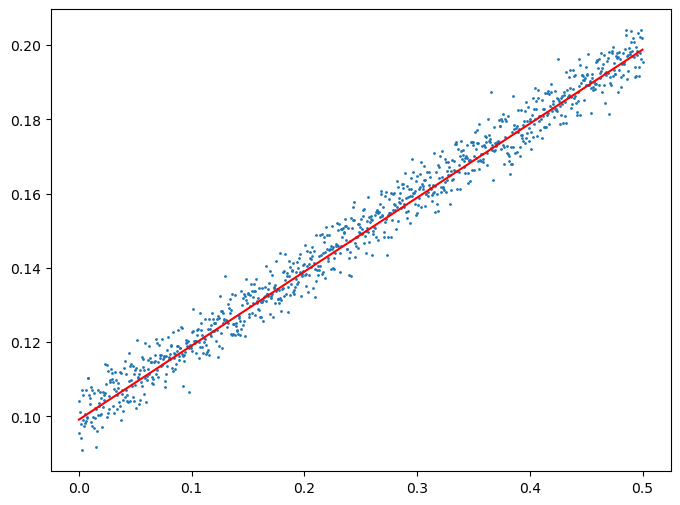

In [6]:
vi_y_hat_train, vi_sd_hat_train = get_bnn_outputs(vi_bnn, x_train_t, K)
vi_y_hat_test, vi_sd_hat_test = get_bnn_outputs(vi_bnn, x_test_t, K)

fig = plt.figure()
plt.scatter(x_train, y_train_t, s=1)
plt.plot(x_train, vi_y_hat_train, c='r')
plt.show()

In [7]:
# model uncertainty for BNN using MCMC
K = 1000

x_train_t, y_train_t, x_test_t, y_test_t = numpy_dataset_to_tensors(x_train, y_train, x_test, y_test)
pyro.clear_param_store()
# build bnn using tyxe, adapted from https://github.com/TyXe-BDL/TyXe/blob/master/notebooks/regression.ipynb
net = torch.nn.Sequential(torch.nn.Linear(1, 4), torch.nn.ReLU(), torch.nn.Linear(4, 1))
prior = tyxe.priors.IIDPrior(pyro.distributions.Normal(0, 1))
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(x_train_t), scale=0.02)
kernel = partial(pyro.infer.mcmc.NUTS, target_accept_prob=0.9)
mcmc_bnn = tyxe.bnn.MCMC_BNN(net, prior, likelihood, kernel)

# train bnn (or load if trained)
model_path = models_dir + 'mcmc_bnn.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
	    mcmc_bnn = dill.load(f)
else:
    mcmc_bnn.fit(get_dataloader(x_train_t, y_train_t), 30000, warmup_steps=3000)
    with open(model_path, 'wb') as f:
	    dill.dump(mcmc_bnn, f)

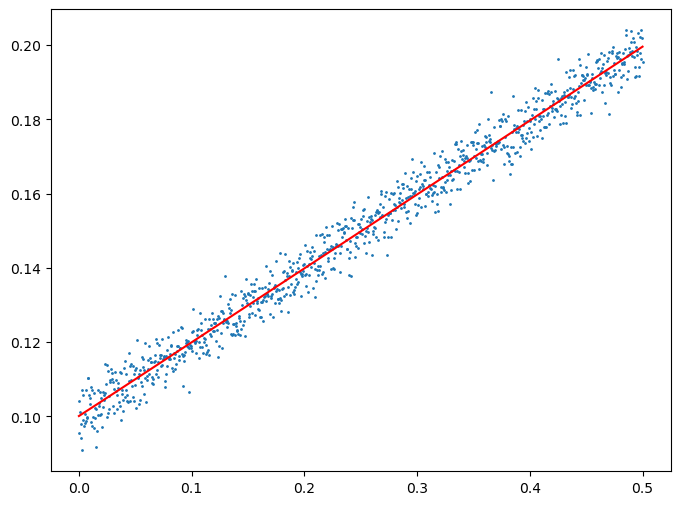

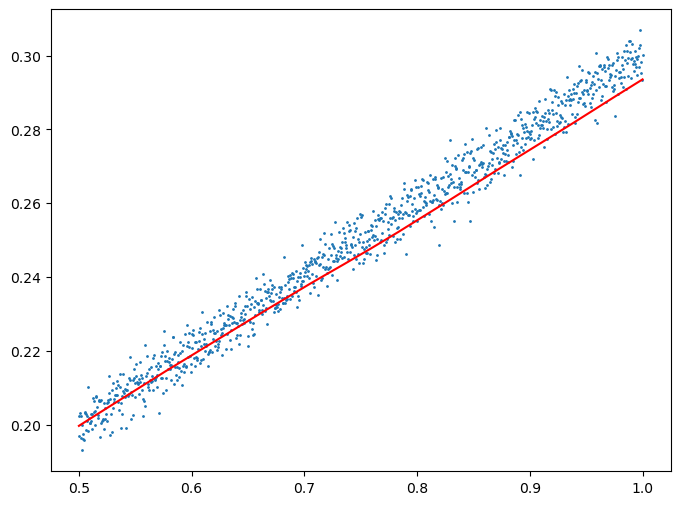

In [8]:
mcmc_y_hat_train, mcmc_sd_hat_train = get_bnn_outputs(mcmc_bnn, x_train_t, K)
mcmc_y_hat_test, mcmc_sd_hat_test = get_bnn_outputs(mcmc_bnn, x_test_t, K)

fig = plt.figure()
plt.scatter(x_train, y_train_t, s=1)
plt.plot(x_train, mcmc_y_hat_train, c='r')
plt.show()
plt.scatter(x_test, y_test_t, s=1)
plt.plot(x_test, mcmc_y_hat_test, c='r')
plt.show()

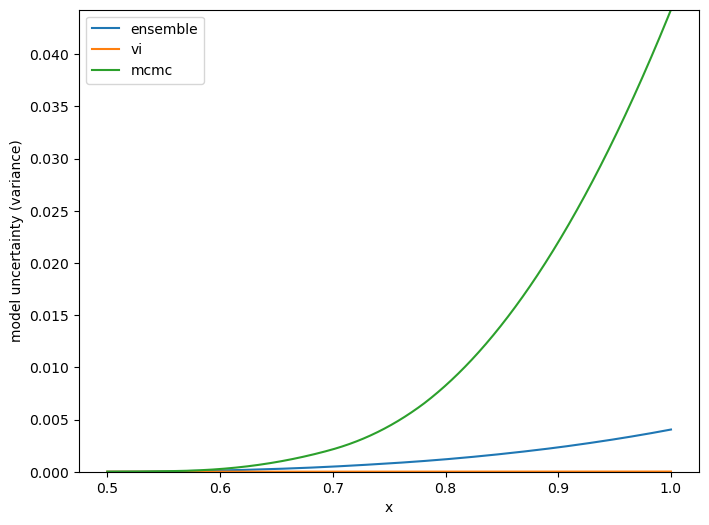

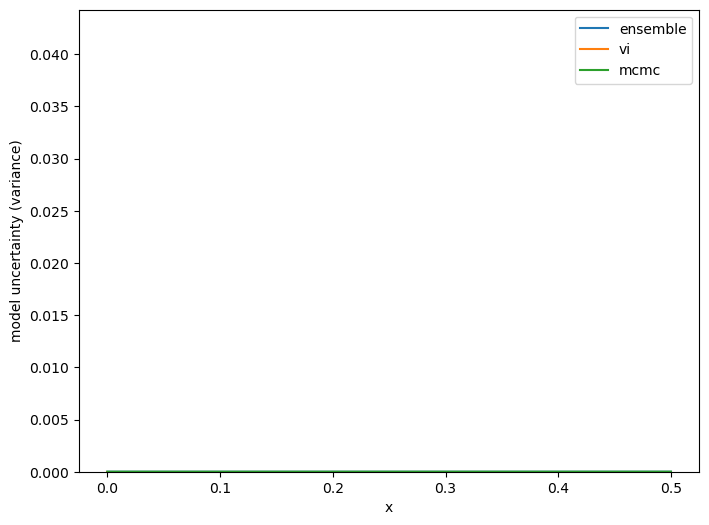

In [14]:
fig = plt.figure()
plt.plot(x_test, ensemble_sd_hat_test**2, label='ensemble')
plt.plot(x_test, vi_sd_hat_test**2, label='vi')
plt.plot(x_test, mcmc_sd_hat_test**2, label='mcmc')
plt.ylim([0, np.max(mcmc_sd_hat_test.numpy()**2)])
save_xy_graph(fig, "x", "model uncertainty (variance)", figures_dir, 'nn_model_unc_var_test.png')

fig = plt.figure()
plt.plot(x_train, ensemble_sd_hat_train**2, label='ensemble')
plt.plot(x_train, vi_sd_hat_train**2, label='vi')
plt.plot(x_train, mcmc_sd_hat_train**2, label='mcmc')
plt.ylim([0, np.max(mcmc_sd_hat_test.numpy()**2)])
save_xy_graph(fig, "x", "model uncertainty (variance)", figures_dir, 'nn_model_unc_var_train.png')

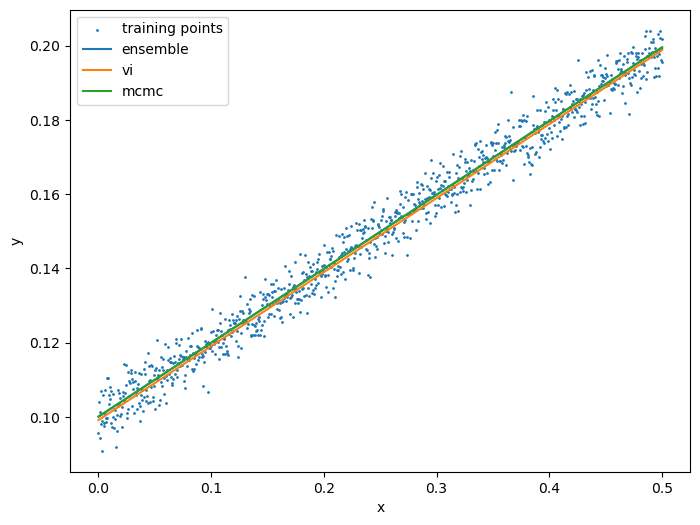

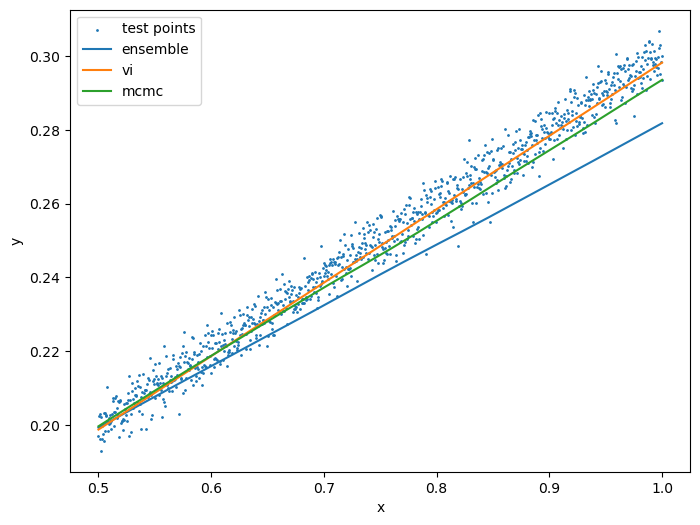

In [10]:
fig = plt.figure()
plt.scatter(x_train, y_train, label='training points', s=1)
plt.plot(x_train, ensemble_y_hat_train, label='ensemble')
plt.plot(x_train, vi_y_hat_train, label='vi')
plt.plot(x_train, mcmc_y_hat_train, label='mcmc')
save_xy_graph(fig, "x", "y", figures_dir, 'nn_model_unc_pred_train.png')

fig = plt.figure()
plt.scatter(x_test, y_test, label='test points', s=1)
plt.plot(x_test, ensemble_y_hat_test, label='ensemble')
plt.plot(x_test, vi_y_hat_test, label='vi')
plt.plot(x_test, mcmc_y_hat_test, label='mcmc')
save_xy_graph(fig, "x", "y", figures_dir, 'nn_model_unc_pred_test.png')